In [1]:
from Bio import SeqIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bisect import bisect
import tools

from tqdm.notebook import tqdm

np.random.seed(42)

Файл 'chromosome1.fasta' содержит **последовательность нуклеотидов** первой хромосомы человека

In [3]:
sequence_data = 'data/chromosome1.fasta'
with open(sequence_data) as file:
    fasta_sequences = SeqIO.parse(file, 'fasta')
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)

Импорт данных 

In [4]:
cds = pd.read_csv('data/cds.csv')
exons = pd.read_csv('data/exons.csv')

In [5]:
exons.head()

,Seqid,Source,Type,Start,End,Score,Strand,Phase
0,NC_000001.11,BestRefSeq,exon,11874,12227,NaN,+,NaN
1,NC_000001.11,BestRefSeq,exon,12613,12721,NaN,+,NaN
2,NC_000001.11,BestRefSeq,exon,13221,14409,NaN,+,NaN
3,NC_000001.11,BestRefSeq,exon,30366,30503,NaN,+,NaN
4,NC_000001.11,BestRefSeq,exon,30438,30458,NaN,+,NaN


In [6]:
cds.head()

,Seqid,Source,Type,Start,End,Score,Strand,Phase
0,NC_000001.11,BestRefSeq,CDS,65565,65573,NaN,+,0
1,NC_000001.11,BestRefSeq,CDS,69037,70008,NaN,+,0
2,NC_000001.11,BestRefSeq,CDS,924432,924948,NaN,+,0
3,NC_000001.11,BestRefSeq,CDS,925922,926013,NaN,+,2
4,NC_000001.11,BestRefSeq,CDS,930155,930336,NaN,+,0


Выделение границ экзонов и кодирующих последовательностей

In [7]:
cds_starts = tools.get_values(cds['Start'])
cds_ends = tools.get_values(cds['End'])

exons_starts = tools.get_values(exons['Start'])
exons_ends = tools.get_values(exons['End'])

Из всех cds нас интересуют начальные (начинаются с **ATG**) и конечные (кончаются на **TAA, TAG, TGA**)

In [10]:
cds_starts_new = []
cds_ends_new = []
    
for start, end in zip(cds_starts, cds_ends):
    
    if (sequence[start-1:start+2] in ['ATG']): 
        cds_starts_new.append(start)
    if (sequence[end-3:end] in ['TAA', 'TAG', 'TGA']):  
        cds_ends_new.append(end)

Чтобы определить последовательность перед cds, необходимо локализовать **ближайший слева** экзон  
Для последовательности после cds - **ближайший справа**

In [11]:
seq_before_cds_location = []
for cds_start in cds_starts_new:
    p = bisect(exons_starts, cds_start)
    seq_before_cds_location.append((exons_starts[p-1], cds_start))
seq_before_cds_location = np.array(seq_before_cds_location)

seq_after_cds_location = []
for cds_end in cds_ends_new:
    p = bisect(exons_ends, cds_end)
    seq_after_cds_location.append((cds_end, exons_ends[p]))
seq_after_cds_location = np.array(seq_after_cds_location)

На выходе имеем массив с границами **участков перед начальной cds** внутри соответствующих экзонов

In [12]:
seq_before_cds_location

array([[    65520,     65565],
       [   923923,    924432],
       [   925922,    925942],
       ...,
       [237678048, 237678048],
       [239907433, 239907452],
       [240091883, 240092110]], dtype=int64)

И массив с границами **участков после последней cds** внутри соответствующих экзонов

In [13]:
seq_after_cds_location

array([[    70008,     71585],
       [   944153,    944574],
       [   965191,    965719],
       ...,
       [248522597, 248527337],
       [248848633, 248849517],
       [248918363, 248919146]], dtype=int64)

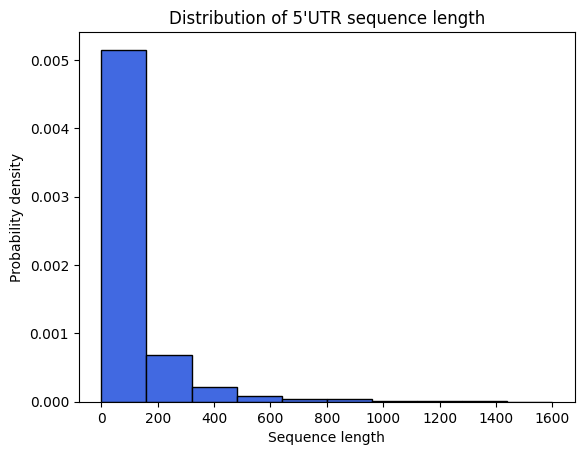

In [16]:
plt.title("Distribution of 5'UTR sequence length")
plt.ylabel('Probability density')
plt.xlabel('Sequence length')
plt.hist(np.diff(seq_before_cds_location), range=(0, 1600), linewidth=1, edgecolor='black', color='royalblue', density=True);

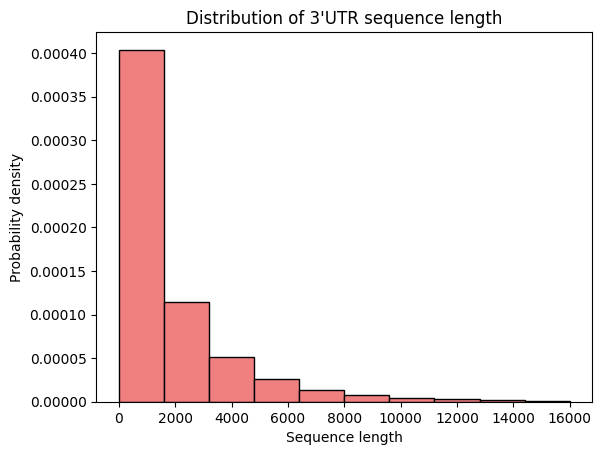

In [17]:
plt.title("Distribution of 3'UTR sequence length")
plt.ylabel('Probability density')
plt.xlabel('Sequence length')
plt.hist(np.diff(seq_after_cds_location), range=(0, 16000), linewidth=1, edgecolor='black', color='lightcoral', density=True);

Ограничим длины последовательностей , чтобы рассчитываемые далее статистики были **релевантны**

In [18]:
start_cds_location_data = tools.limit(seq_before_cds_location, min_length=16, max_length=1600)
start_cds_location_data.to_csv('data/start_cds_location.csv', index=False)

end_cds_location_data = tools.limit(seq_after_cds_location, min_length=16, max_length=16000)
end_cds_location_data.to_csv('data/end_cds_location.csv', index=False)

In [19]:
start_cds_location_data.head()

,start,end
0,65519,65564
1,923922,924431
2,925921,925941
3,960583,960693
4,966481,966531


In [20]:
end_cds_location_data.head()

,start,end
0,70007,71584
1,944152,944573
2,965190,965718
3,974574,975864
4,1014477,1014539


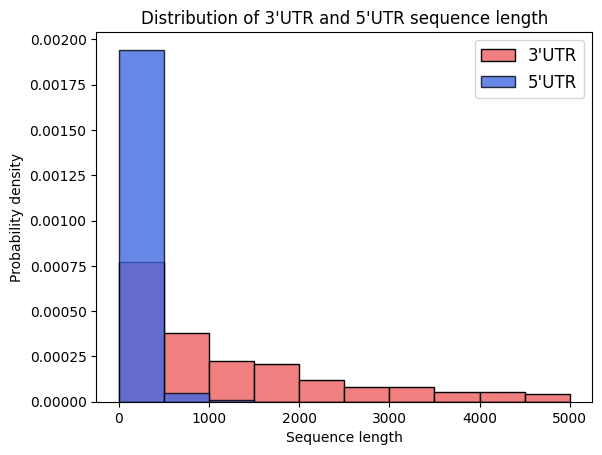

In [30]:
plt.title("Distribution of 3'UTR and 5'UTR sequence length")
plt.ylabel('Probability density')
plt.xlabel('Sequence length')
plt.hist(np.diff(seq_after_cds_location), range=(0, 5000), linewidth=1, edgecolor='black', color='lightcoral', density=True, label="3'UTR")
plt.hist(np.diff(seq_before_cds_location), range=(0, 5000), linewidth=1, edgecolor='black', color='royalblue', density=True, label="5'UTR", alpha=0.8)
plt.legend(fontsize='large')

Используя список границ областей интереса, вырежем эти области из исходной последовательности

In [31]:
seq_before_cds = tools.get_sequence(start_cds_location_data, sequence)
seq_after_cds = tools.get_sequence(end_cds_location_data, sequence)

In [32]:
len(seq_before_cds), len(seq_after_cds)

(1195, 1558)

Далее необходимо создать аналогичную **выборку для класса 0**, то есть последовательностей, которые **не расположены** перед cds  
Для этого выбираем случайный нуклеотид в цепочке и вырезаем последовательность **длинной L**  
**Число L** определяется из **экспоненциального распределения**, близкого к распределению длин искомых последовательностей  

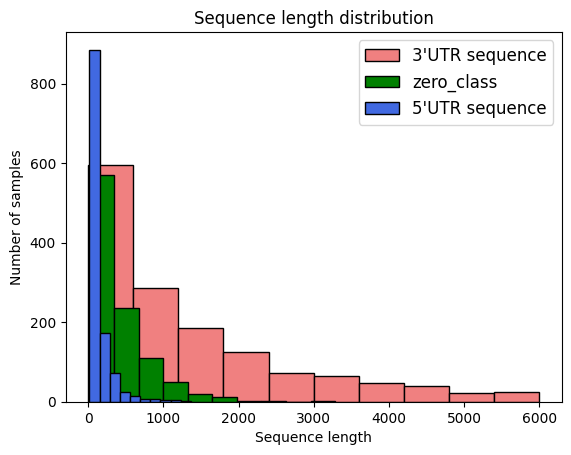

In [33]:
plt.title('Sequence length distribution')
plt.ylabel('Number of samples')
plt.xlabel('Sequence length')
z = np.random.exponential(scale=400.0, size=1000)+16
plt.hist(np.diff(end_cds_location_data), label="3'UTR sequence", range=(0, 6000), linewidth=1, edgecolor='black', color='lightcoral')
plt.hist(z, label='zero_class', linewidth=1, edgecolor='black', color='green') #L distribution
plt.hist(np.diff(start_cds_location_data), label="5'UTR sequence", linewidth=1, edgecolor='black', color='royalblue')
plt.legend(fontsize='large')

Дополнительно мы убеждаемся, что выбранные последовательности класса 0 **не пересекаются** с границами последовательностей класса 1

In [34]:
n = 2000
seq_zero_location = []
for sample in range(n):
    b = np.random.randint(1e4, 2e8)
    scale = np.random.randint(200, 600)
    L = int(np.random.exponential(scale=scale)+16)
    bounds = (b, b+L)
    
    flag = tools.check_intersection(bounds, start_cds_location_data, end_cds_location_data)
    
    if flag:
        seq_zero_location.append(bounds)        

Ниже можно увидеть, сколько примеров класса 0 пересекались с примерами класса 1 и **были исключены**

In [35]:
print(f'Количество исключенных примеров: {n - len(seq_zero_location)}')

Количество исключенных примеров: 34


Дополнительно необходимо **исключить взаимные пересечения** примеров класса 0, чтобы **избежать утечки данных** при разбиении датасета

In [36]:
seq_zero_location_new = tools.check_self_intersection(seq_zero_location)

100%|██████████| 1966/1966 [00:02<00:00, 889.78it/s] 


In [37]:
print(f'Общее количество исключенных примеров: {n - len(seq_zero_location_new)}')

Общее количество исключенных примеров: 43


Используя полученные **границы последовательностей** класса 0, вырезаем их из исходной последовательности

In [38]:
seq_zero = tools.get_sequence(seq_zero_location, sequence)

Дополнительном отфильтруем последовательности, удалив те из них, которые **содержат пропуски (N)**

In [39]:
seq_zero_new = []
for seq in seq_zero:
    if 'N' not in seq:
        seq_zero_new.append(seq)
        
print(f'Число удаленных последовательностей с пропусками: {len(seq_zero)-len(seq_zero_new)}')

Число удаленных последовательностей с пропусками: 203


По полученным кусочкам последовательности рассчитываем признаки используя функцию **calculate_kmer_features**

In [40]:
start_data = tools.calculate_features(seq_before_cds)
end_data = tools.calculate_features(seq_after_cds)
zero_data = tools.calculate_features(seq_zero_new)

In [41]:
start_data.head()

,A,T,G,C,AT,GC,GA,GT,GG,CG,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
0,0.126905,0.216171,0.116436,0.136651,0.064570,0.047726,0.027863,0.079453,0.000000,0.000000,...,0.000000,0.000000,0.027863,0.000000,0.027863,0.000000,0.027863,0.000000,0.000000,0.000000
1,0.082616,0.081422,0.210323,0.188503,0.014111,0.119088,0.055010,0.032336,0.108594,0.115360,...,0.026727,0.077779,0.003623,0.011733,0.006557,0.032336,0.016389,0.070187,0.024772,0.056468
2,0.189255,0.137504,0.174349,0.114447,0.000000,0.052558,0.114447,0.052558,0.052558,0.052558,...,0.052558,0.000000,0.000000,0.000000,0.086934,0.052558,0.000000,0.000000,0.000000,0.000000
3,0.108048,0.088818,0.189905,0.189905,0.013003,0.103477,0.060316,0.060316,0.066524,0.112478,...,0.013003,0.039512,0.000000,0.031580,0.013003,0.013003,0.022881,0.053784,0.039512,0.039512
4,0.133034,0.115308,0.181281,0.169294,0.000000,0.057879,0.095068,0.042620,0.083758,0.042620,...,0.083758,0.042620,0.024758,0.000000,0.000000,0.057879,0.024758,0.000000,0.024758,0.024758


In [42]:
end_data.head()

,A,T,G,C,AT,GC,GA,GT,GG,CG,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
0,0.192964,0.173143,0.119543,0.111952,0.090100,0.028510,0.059276,0.049778,0.032095,0.005459,...,0.011416,0.008131,0.017386,0.012200,0.029721,0.019478,0.020161,0.000000,0.015952,0.009806
1,0.156318,0.132014,0.169294,0.158856,0.035617,0.070184,0.056827,0.043809,0.079381,0.033460,...,0.021807,0.024274,0.004296,0.024274,0.021807,0.031252,0.021807,0.004296,0.021807,0.028989
2,0.118410,0.154121,0.161416,0.173673,0.041230,0.069250,0.038011,0.061495,0.062820,0.045883,...,0.015811,0.023918,0.003489,0.027659,0.006317,0.021978,0.025810,0.017932,0.021978,0.034685
3,0.143987,0.116651,0.174323,0.171919,0.022851,0.068534,0.074116,0.048353,0.070080,0.029725,...,0.014367,0.028246,0.004176,0.024430,0.024430,0.028988,0.021238,0.007539,0.045260,0.035409
4,0.182432,0.100963,0.172808,0.144756,0.049853,0.072679,0.072679,0.036540,0.072679,0.036540,...,0.000000,0.049853,0.021095,0.036540,0.036540,0.036540,0.000000,0.000000,0.036540,0.036540


In [43]:
zero_data.head()

,A,T,G,C,AT,GC,GA,GT,GG,CG,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
0,0.145557,0.204623,0.116988,0.131223,0.081929,0.038612,0.043724,0.054200,0.030990,0.020099,...,0.012502,0.010230,0.011757,0.010230,0.012502,0.011000,0.017445,0.006138,0.009446,0.008647
1,0.182097,0.178541,0.129702,0.105774,0.089228,0.025404,0.066386,0.060732,0.036782,0.009477,...,0.016817,0.006735,0.021240,0.006735,0.025404,0.016817,0.019065,0.003723,0.016817,0.003723
2,0.149543,0.138255,0.160566,0.162417,0.052907,0.065878,0.056942,0.044393,0.068321,0.050138,...,0.017310,0.026724,0.008578,0.023101,0.024933,0.028476,0.024933,0.019296,0.019296,0.024933
3,0.192293,0.138786,0.141574,0.131693,0.066052,0.048531,0.065621,0.044489,0.050011,0.013655,...,0.022702,0.022702,0.017289,0.020049,0.026514,0.024631,0.021388,0.005427,0.025892,0.015136
4,0.170262,0.166200,0.133446,0.137364,0.060574,0.048855,0.069217,0.053681,0.023905,0.020644,...,0.000000,0.009712,0.000000,0.020644,0.035788,0.017224,0.017224,0.000000,0.032961,0.005406


In [44]:
print(f'Количество примеров: перед cds: {start_data.shape[0]}, после cds: {end_data.shape[0]}, остальное: {zero_data.shape[0]}')

Количество примеров: перед cds: 1195, после cds: 1558, остальное: 1763


Дополним таблицы колонкой **target** и объединим в **2 таблицы**:  
в **первой таблице** класс 1 - участки **перед cds**, остальное 0  
во **второй таблице** класс 1 - участки **после cds**, остальное 0  

In [45]:
start_data.loc[:, 'target'] = 1
end_data.loc[:, 'target'] = 0
zero_data.loc[:, 'target'] = 0

start_data_final = pd.concat([start_data, end_data, zero_data], axis=0)

In [46]:
start_data.loc[:, 'target'] = 0
end_data.loc[:, 'target'] = 1
zero_data.loc[:, 'target'] = 0

end_data_final = pd.concat([end_data, start_data, zero_data], axis=0)

In [47]:
start_data_final

,A,T,G,C,AT,GC,GA,GT,GG,CG,...,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG,target
0,0.126905,0.216171,0.116436,0.136651,0.064570,0.047726,0.027863,0.079453,0.000000,0.000000,...,0.000000,0.027863,0.000000,0.027863,0.000000,0.027863,0.000000,0.000000,0.000000,1
1,0.082616,0.081422,0.210323,0.188503,0.014111,0.119088,0.055010,0.032336,0.108594,0.115360,...,0.077779,0.003623,0.011733,0.006557,0.032336,0.016389,0.070187,0.024772,0.056468,1
2,0.189255,0.137504,0.174349,0.114447,0.000000,0.052558,0.114447,0.052558,0.052558,0.052558,...,0.000000,0.000000,0.000000,0.086934,0.052558,0.000000,0.000000,0.000000,0.000000,1
3,0.108048,0.088818,0.189905,0.189905,0.013003,0.103477,0.060316,0.060316,0.066524,0.112478,...,0.039512,0.000000,0.031580,0.013003,0.013003,0.022881,0.053784,0.039512,0.039512,1
4,0.133034,0.115308,0.181281,0.169294,0.000000,0.057879,0.095068,0.042620,0.083758,0.042620,...,0.042620,0.024758,0.000000,0.000000,0.057879,0.024758,0.000000,0.024758,0.024758,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,0.101112,0.153356,0.153356,0.193110,0.024965,0.078319,0.034390,0.034390,0.058327,0.024965,...,0.034390,0.000000,0.024965,0.014225,0.014225,0.024965,0.014225,0.014225,0.034390,0
1759,0.116495,0.113719,0.160184,0.201637,0.022371,0.088219,0.045106,0.040312,0.059769,0.052664,...,0.028146,0.006436,0.026267,0.006436,0.020344,0.026267,0.018256,0.020344,0.024343,0
1760,0.164361,0.172319,0.131816,0.146748,0.072306,0.061891,0.048135,0.040592,0.040592,0.040592,...,0.020320,0.020320,0.020320,0.023532,0.020320,0.013384,0.009554,0.016950,0.013384,0
1761,0.158825,0.164557,0.141707,0.144429,0.065055,0.054058,0.064373,0.046393,0.043583,0.013570,...,0.014735,0.013570,0.026322,0.022325,0.020770,0.019179,0.002834,0.022836,0.015309,0


In [48]:
end_data_final

,A,T,G,C,AT,GC,GA,GT,GG,CG,...,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG,target
0,0.192964,0.173143,0.119543,0.111952,0.090100,0.028510,0.059276,0.049778,0.032095,0.005459,...,0.008131,0.017386,0.012200,0.029721,0.019478,0.020161,0.000000,0.015952,0.009806,1
1,0.156318,0.132014,0.169294,0.158856,0.035617,0.070184,0.056827,0.043809,0.079381,0.033460,...,0.024274,0.004296,0.024274,0.021807,0.031252,0.021807,0.004296,0.021807,0.028989,1
2,0.118410,0.154121,0.161416,0.173673,0.041230,0.069250,0.038011,0.061495,0.062820,0.045883,...,0.023918,0.003489,0.027659,0.006317,0.021978,0.025810,0.017932,0.021978,0.034685,1
3,0.143987,0.116651,0.174323,0.171919,0.022851,0.068534,0.074116,0.048353,0.070080,0.029725,...,0.028246,0.004176,0.024430,0.024430,0.028988,0.021238,0.007539,0.045260,0.035409,1
4,0.182432,0.100963,0.172808,0.144756,0.049853,0.072679,0.072679,0.036540,0.072679,0.036540,...,0.049853,0.021095,0.036540,0.036540,0.036540,0.000000,0.000000,0.036540,0.036540,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,0.101112,0.153356,0.153356,0.193110,0.024965,0.078319,0.034390,0.034390,0.058327,0.024965,...,0.034390,0.000000,0.024965,0.014225,0.014225,0.024965,0.014225,0.014225,0.034390,0
1759,0.116495,0.113719,0.160184,0.201637,0.022371,0.088219,0.045106,0.040312,0.059769,0.052664,...,0.028146,0.006436,0.026267,0.006436,0.020344,0.026267,0.018256,0.020344,0.024343,0
1760,0.164361,0.172319,0.131816,0.146748,0.072306,0.061891,0.048135,0.040592,0.040592,0.040592,...,0.020320,0.020320,0.020320,0.023532,0.020320,0.013384,0.009554,0.016950,0.013384,0
1761,0.158825,0.164557,0.141707,0.144429,0.065055,0.054058,0.064373,0.046393,0.043583,0.013570,...,0.014735,0.013570,0.026322,0.022325,0.020770,0.019179,0.002834,0.022836,0.015309,0


На этом предобработка завершена, сохраняем ;)

In [49]:
start_data_final.to_csv('data/start_features.csv', index=False)
end_data_final.to_csv('data/end_features.csv', index=False)